In [1]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from torchinfo import summary

import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.set_default_device(device)
torch.set_num_threads(1)

In [3]:
train_kwargs = { 'batch_size': 256 }
test_kwargs = { 'batch_size': 256 }
if use_cuda:
    train_kwargs.update({ 'num_workers': 2, 'pin_memory': True, 'shuffle': True })
    test_kwargs.update({ 'num_workers': 2, 'pin_memory': True, 'shuffle': True })

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, generator=torch.Generator(device), **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, generator=torch.Generator(device), **test_kwargs)

In [5]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()

        self.seq = nn.Sequential(
            nn.Conv2d(1, 8, 3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(8, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(5 * 5 * 16, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x: torch.Tensor):
        output = self.seq(x)
        return output

In [6]:
model = Net().to(device)
critereon = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [7]:
summary(model, input_size=(256, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [256, 10]                 --
├─Sequential: 1-1                        [256, 10]                 --
│    └─Conv2d: 2-1                       [256, 8, 26, 26]          80
│    └─BatchNorm2d: 2-2                  [256, 8, 26, 26]          16
│    └─ReLU: 2-3                         [256, 8, 26, 26]          --
│    └─MaxPool2d: 2-4                    [256, 8, 13, 13]          --
│    └─Conv2d: 2-5                       [256, 16, 11, 11]         1,168
│    └─BatchNorm2d: 2-6                  [256, 16, 11, 11]         32
│    └─ReLU: 2-7                         [256, 16, 11, 11]         --
│    └─MaxPool2d: 2-8                    [256, 16, 5, 5]           --
│    └─Flatten: 2-9                      [256, 400]                --
│    └─Linear: 2-10                      [256, 10]                 4,010
│    └─LogSoftmax: 2-11                  [256, 10]                 --
Total par

In [8]:
def train(model: nn.Module, device: torch.device, train_loader: torch.utils.data.DataLoader, optimizer: optim.Optimizer, epoch: int):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        start = time.perf_counter_ns()
        optimizer.zero_grad()
        output = model(data)
        loss = critereon(output, target)
        loss.backward()
        optimizer.step()
        end = (time.perf_counter_ns() - start) / 1000.0 / 1000.0
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTime: {:.3f}ms'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), end)
            )

In [9]:
def test(model: nn.Module, device: torch.device, test_loader: torch.utils.data.DataLoader):
    model.eval()
    test_loss = 0
    correct = 0

    start = time.perf_counter_ns()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += critereon(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
    test_loss /= len(test_loader.dataset)

    end = (time.perf_counter_ns() - start) / 1000.0 / 1000.0
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\tTime: {:.3f}ms\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset), end)
    )

In [10]:
epochs = 25

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    # exp_lr_scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.418124	Time: 78.723ms
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.337672	Time: 3.891ms
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.100551	Time: 4.753ms

Test set: Average loss: 0.0005, Accuracy: 9663/10000 (97%)	Time: 4443.606ms

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.110041	Time: 30.200ms
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.088774	Time: 4.154ms
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.095760	Time: 5.252ms

Test set: Average loss: 0.0003, Accuracy: 9786/10000 (98%)	Time: 4406.374ms

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.049331	Time: 30.908ms
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.073313	Time: 4.312ms
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.080331	Time: 4.817ms

Test set: Average loss: 0.0002, Accuracy: 9823/10000 (98%)	Time: 4416.755ms

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.066882	Time: 31.215ms
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.045712	Time: 3.970ms
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.036299	Time: 5.834ms

Test set: Ave

<Axes: >

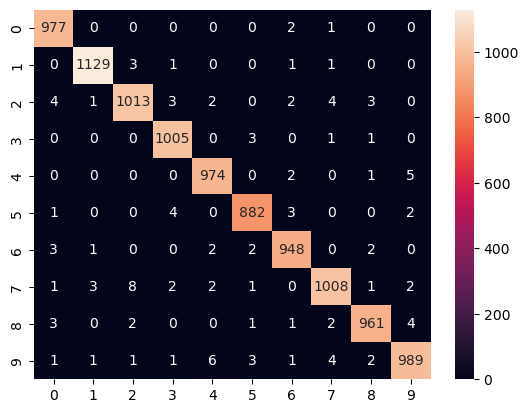

In [11]:
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        all_preds.extend(pred.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

conf_matrix = confusion_matrix(all_targets, all_preds)

sns.heatmap(conf_matrix, annot=True, fmt='d')